In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import altair as alt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from scripts.utils import *
from scripts.plotting import *
from itertools import product

# Short term stock forecaster

In [2]:
ticker = 'SU'
stock = yf.Ticker(ticker)
# stock.info

# get historical market data
hist = stock.history(period="max")
hist = hist.resample('D').mean()
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15433 entries, 1980-03-17 to 2022-06-17
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9675 non-null   float64
 1   High          9675 non-null   float64
 2   Low           9675 non-null   float64
 3   Close         9675 non-null   float64
 4   Volume        9675 non-null   float64
 5   Dividends     9675 non-null   float64
 6   Stock Splits  9675 non-null   float64
dtypes: float64(7)
memory usage: 964.6 KB


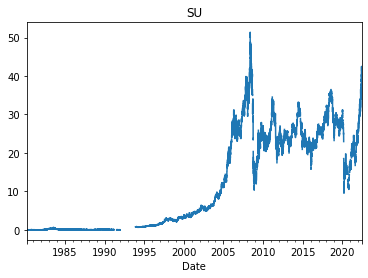

In [3]:
hist['Close'].plot()
plt.title(ticker);

/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


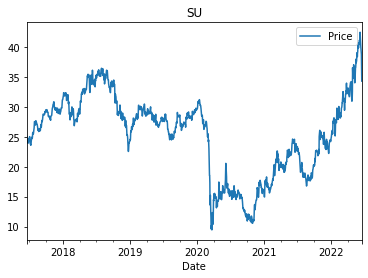

In [4]:
# input desired forecast window in years
period = 5
hist_impute = hist.interpolate(method="polynomial", order=2)
hist_impute.index.freq = 'D'
end_date = hist_impute.index[-1]
train_start = end_date - period*365*hist_impute.index.freq
hist_trim = pd.DataFrame({'Price': hist_impute.loc[train_start:end_date, 'Close'],
                         'Label': 'Data'})
hist_trim.plot()
plt.title(ticker)

train_df, valid_df = train_test_split(hist_trim, test_size=0.2, shuffle=False)
train_df['Label'] = 'Train'
valid_df['Label'] = 'Valid'

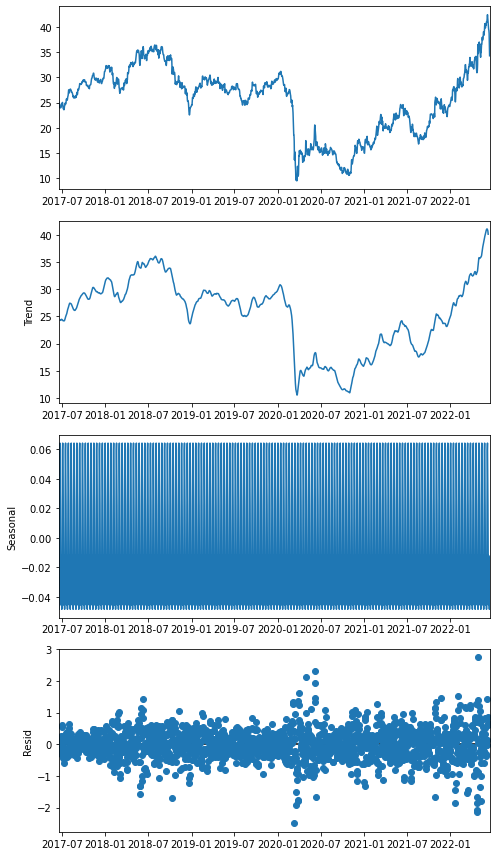

In [5]:
import matplotlib as mpl
model = seasonal_decompose(hist_trim[["Price"]], model="additive", period=12)
with mpl.rc_context():  # this context manager help adjust the size of the plot
    mpl.rc("figure", figsize=(7, 12))
    model.plot()
    plt.tight_layout()

In [6]:
def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")

## Train model on training data, find optimum params

In [7]:
valid_index = create_forecast_index(train_df.index[-1], horizon=len(valid_df.index), freq="d")

In [8]:
# ARIMA
optimum_model = {"aic": np.inf}
for p, d, q in product(range(4), range(4), range(4)):
    model = ARIMA(train_df['Price'], order=(p, d, q)).fit()
    if model.aic < optimum_model["aic"]:
        optimum_model["aic"] = model.aic
        optimum_model["order"] = (p, d, q)
print(optimum_model)
arima_params = optimum_model['order']

/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: Conv

{'aic': 1406.7600589738695, 'order': (2, 1, 3)}


/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [9]:
# ETS
optimum_model = {"aic": np.inf}

for e, t, s, d in product(['add', 'mul'], ['add', 'mul'], ['add', 'mul'], [True, False]):
    model = ETSModel(train_df['Price'], error=e, trend=t, seasonal=s, damped_trend=d).fit()
    if model.aic < optimum_model["aic"]:
        optimum_model["aic"] = model.aic
        optimum_model["order"] = (e, t, s, d)
print(optimum_model)
ets_params = optimum_model['order']

{'aic': 1544.6840245243109, 'order': ('add', 'add', 'add', True)}


In [10]:
# Prophet
prophet_df = pd.DataFrame({"ds": train_df.index,
                           "y": train_df["Price"].to_numpy()}, index=None)
model_proph = Prophet(interval_width=0.95)
model_proph.fit(prophet_df);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Test models on validation set, return highest performing model

In [11]:
# Arima
model_arima = ARIMA(train_df['Price'], order=(arima_params[0], arima_params[1], arima_params[2])).fit()
forecast_arima = pd.DataFrame({"Price": model_arima.forecast(len(valid_index)),
                                "Label": "ARIMA"},
                               index=valid_index)

In [12]:
# ETS
model_ets = ETSModel(train_df['Price'], error=ets_params[0], trend=ets_params[1], seasonal=ets_params[2], damped_trend=ets_params[3]).fit()
forecast_ets = pd.DataFrame({"Price": model_ets.forecast(len(valid_index)),
                                "Label": "ETS"},
                               index=valid_index)


In [13]:
# Prophet
test_dates = model_proph.make_future_dataframe(periods=len(valid_df), freq="D", include_history=False)
forecasts_proph = model_proph.predict(test_dates)

prophet_forecast_valid = pd.DataFrame({"Price": forecasts_proph['yhat'].to_numpy(),
                                "Label": "Prophet"},
                               index=valid_index)

In [14]:
# check validation results
alt.data_transformers.enable('data_server') # allows plotting more than 5000 rows of data

df = pd.concat((train_df, valid_df, forecast_arima, forecast_ets, prophet_forecast_valid))

alt.Chart(df.reset_index(), title=ticker).mark_line().encode(
    x=alt.X('index:T', title='Date'),
    y='Price:Q',
    color="Label",
    tooltip=['Price', 'index']
).properties(width=800, height=600)

alt.Chart(...)

In [15]:
# Check MAPE
from sklearn.metrics import mean_absolute_percentage_error
forecasts = {'ets': forecast_ets, 'arima': forecast_arima, 'prophet': prophet_forecast_valid}

def MAPE(models):
    error = np.inf
    best_forecast = None
    label = None
    results = {}
    
    for label, model in forecasts.items():
        results[label] = mean_absolute_percentage_error(y_true=valid_df['Price'], y_pred=model['Price'])
        if results[label] < error:
            best_forecast = model
            error = results[label]
            best_label = label
    return best_forecast, error, best_label, results

best_fcast, error, best_label, results = MAPE(models)
print(f"Best model: {best_label}, Error: {error:.2f}")
pd.DataFrame(results, index=['MAPE']).T

ImportError: cannot import name 'mean_absolute_percentage_error' from 'sklearn.metrics' (/opt/miniconda3/envs/mds574/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

## Return forecast as plot and df

In [ ]:
forecast_horizon = 365
forecast_index = create_forecast_index(hist_impute.index[-1], horizon=forecast_horizon, freq="d")

In [ ]:
# if best_label == 'arima':
model = ARIMA(hist_trim['Price'], order=(arima_params[0], arima_params[1], arima_params[2])).fit()
arima_forecast = pd.DataFrame({"Price": model.forecast(len(forecast_index)),
                                "Label": "ARIMA"},
                               index=forecast_index)

# else:
model = ETSModel(hist_trim['Price'], error=ets_params[0], trend=ets_params[1], seasonal=ets_params[2], damped_trend=ets_params[3]).fit()
ets_forecast = pd.DataFrame({"Price": model.forecast(len(forecast_index)),
                                "Label": "ETS"},
                               index=forecast_index)


prophet_df = pd.DataFrame({"ds": hist_trim.index,
                           "y": hist_trim["Price"].to_numpy()}, index=None)
model_proph = Prophet(interval_width=0.95)
model_proph.fit(prophet_df);
test_dates = model_proph.make_future_dataframe(periods=len(forecast_index), freq="D", include_history=False)
forecasts_proph = model_proph.predict(test_dates)

prophet_forecast = pd.DataFrame({"Price": forecasts_proph['yhat'].to_numpy(),
                                "Label": "Prophet"},
                               index=forecast_index)


In [ ]:
alt.data_transformers.enable('data_server') # allows plotting more than 5000 rows of data

df = pd.concat((hist_trim, arima_forecast, ets_forecast, prophet_forecast))

alt.Chart(df.reset_index(), title=ticker).mark_line().encode(
    x=alt.X('index:T', title='Date'),
    y='Price:Q',
    color="Label",
    tooltip=['Price', 'index']
).properties(width=800, height=600)

In [ ]:
prophet = (
    forecasts_proph.loc[:, ["yhat", "yhat_lower", "yhat_upper"]]
    .rename(columns={"yhat_lower": "pi_lower", "yhat_upper": "pi_upper"})
    .set_index(prophet_forecast.index)
)
plot_prediction_intervals(
    hist_trim['Price'], prophet, "yhat"
)

In [ ]:
df.query("Label == 'Prophet'")

In [ ]:
stock.major_holders

In [ ]:
# stock.info
stock.quarterly_earnings

INFO:tornado.access:200 GET /7e14f41ce81fb9d97b25049ff3dc049d.json (::1) 10.27ms
